In [1]:
# %load data_prep.py
# %load data_prep.py
import sys
import os
import pandas as pd
import numpy as np
import epiweeks as epi
import datetime
import argparse
import time
import re
import shutil
import pdb

from pandas import Series
from datetime import date, time, datetime, timedelta
from scipy import signal

def data_read_and_prep(csv_path, epwk, yr, test_wks=4, wght=False, log_tr=False):
    # Read in the historical ILI data from startdate given by epwk and year from the csv_path and 
    #   create train and test set 
    cdcdf = pd.read_csv(csv_path, header=1)
    df = cdcdf.drop(["REGION", "REGION TYPE", "AGE 0-4", "AGE 25-49", "AGE 25-64", "AGE 5-24", "AGE 50-64", "AGE 65", "NUM. OF PROVIDERS"], axis=1)


    df['DATE'] = pd.to_datetime(df.apply(lambda row : epi.Week(int(row["YEAR"]), int(row["WEEK"])).startdate() ,axis=1, result_type='reduce'))

    
    week=epi.Week(yr, epwk)

    df_train = df[(df['DATE']<=pd.to_datetime(week.startdate()))]
    df_test = df[(df['DATE']>pd.to_datetime(week.startdate()))&((df['DATE']<=pd.to_datetime(week.startdate())+timedelta(weeks=test_wks)))]
    if wght:
        train = df_train['% WEIGHTED ILI']
        test = df_test['% WEIGHTED ILI']
    else:
        train = df_train['%UNWEIGHTED ILI']
        test = df_test['%UNWEIGHTED ILI']
    if log_tr:
        train = np.log(train)
        test = np.log(test)
    train.index = df_train['DATE']
    test.index = df_test['DATE']
    return train, test, df, df_train, df_test

def get_season(y,fft_len=1024,figs=False):
    f, Pxx_den = signal.periodogram(y, nfft=fft_len)
    Pxx_den = np.abs(Pxx_den)
    season_ind = round(fft_len/Pxx_den.argmax())
    print('Season index {}'.format(season_ind))
    return int(season_ind)

def hist_win(y,win):
    y_hist = y[(-win-1):-1]
    return y_hist

def prepdata_append():
    national = pd.read_csv('data/national/ILINet.csv', header=1)
    regional = national.append(pd.read_csv('data/regional/ILINet.csv', header=1))
    df = regional.append(pd.read_csv('data/state/ILINet.csv', header=1))
    return df

def prepdata(csv_path):

    df = pd.read_csv(csv_path, na_values='X', header=1)
    df['REGION'] = df['REGION'].fillna('National')
    df['DATE'] = pd.to_datetime(df.apply(lambda row : epi.Week(int(row["YEAR"]), int(row["WEEK"])).startdate() ,axis=1, result_type='reduce'))
    return df

def prepdata_retro(csv_path,epwk):
    nat_csv_file = csv_path + '/' +'national/'+'ILINet_National_' + epwk + '.csv'
    df = pd.read_csv(nat_csv_file, na_values='X')
    
    hhs_csv_file = csv_path +'/'+'hhs/'+'ILINet_HHS_' + epwk + '.csv'
    df = df.append(pd.read_csv(hhs_csv_file,na_values='X'))
    df['REGION'] = df['REGION'].fillna('National')
    df['DATE'] = pd.to_datetime(df.apply(lambda row : epi.Week(int(row["YEAR"]), int(row["WEEK"])).startdate() ,axis=1, result_type='reduce'))


        #df.set_index(['DATE'], inplace=True)

    #if region == 'US National':
    #    df = cdcdf[cdcdf['REGION TYPE']=='National']
    #    df['DATE'] = pd.to_datetime(df.apply(lambda row : epi.Week(int(row["YEAR"]), int(row["WEEK"])).startdate() ,axis=1, result_type='reduce'))
    #    #df.set_index(['DATE'], inplace=True)

    #elif region.isdigit():
    #    df = cdcdf[cdcdf['REGION']== "Region " + str(region)]
    #    df['DATE'] = pd.to_datetime(df.apply(lambda row : epi.Week(int(row["YEAR"]), int(row["WEEK"])).startdate() ,axis=1, result_type='reduce'))
    #    #df.set_index(['DATE'], inplace=True)

    #    #When I set the date row as the index, I can no longer access it using df['DATE]
    #else:
    #    df = cdcdf[cdcdf['REGION']==region]
    #    
    #    df['DATE'] = pd.to_datetime(df.apply(lambda row : epi.Week(int(row["YEAR"]), int(row["WEEK"])).startdate() ,axis=1, result_type='reduce'))
        #df.set_index(['DATE'], inplace=True)

    return df

def prep_aw_data(aw_csv_path, mask):
    df_ex = pd.read_csv(aw_csv_path)
    pp = pd.to_datetime([epi.Week(int(cdc_data.date2ew(d.date())[0]),int(cdc_data.date2ew(d.date())[1])).startdate() for d in pd.to_datetime(df_ex.date)])
    df_ex['ep_st_date'] = pp
    df_ex.index = pp
    df_ex.index = df_ex.index.rename('DATE')
    df_ex = df_ex[~df_ex.area_id.isin([72,78])]
    df_st_id = pd.read_csv('../data/fips_to_statename.csv')
    df_ex['REGION'] = df_ex.apply(lambda row: df_st_id[df_st_id['area_id']==row['area_id']]['REGION'].values[0], axis=1)

    return(df_ex)

In [2]:
# %load ARLR.py
'''Contains functions that correspond to the ARLR method'''
from statsmodels.tsa.ar_model import AR
import numpy as np
import statsmodels.api as sm
#import matplotlib.pyplot as plt
import pandas as pd
import pdb, os
from aw_micro import cdc_data
import datetime
# ARLR functions
def ARLR_aug_phase(train,lags,win,llr_tol=1e-2):
    y = np.flip(train)
    y_obs = y[0:win]
    ind = y_obs.index
    y_obs = np.array(y_obs.values)
    lags = list(lags)
    lags_chk = np.array(lags).astype(int)
    lags_app = np.array([]).astype(int)
    err_old = np.linalg.norm(y_obs)#np.random.randn(win,1))
    tr_tp = np.zeros([win,len(lags)])
    init_lags_len = len(lags)
    for k in range(0,init_lags_len):
        err_m = np.zeros([len(lags_chk)])
        llr = np.zeros([len(lags_chk)])
        jj = 0
        for i in lags_chk:
#             pdb.set_trace()
            tr_tp[:,k] = y[i:(win+i)]
            tr_tp_mul = np.matmul(tr_tp[:,0:(k+1)].T, tr_tp[:,0:(k+1)])
            res = sm.OLS(y_obs,tr_tp[:,0:(k+1)]).fit()
            yp = res.predict()
            err_m[jj] = np.linalg.norm(y_obs-yp)
            llr[jj] = 2*np.log(err_old/err_m[jj])
#             pdb.set_trace()
            jj+=1            
        imax = np.argmax(llr)
    #     p_val = chi2.sf(llr[imax],1)
    #     print(p_val)
        if llr[imax] >= llr_tol:
#             pdb.set_trace()
            tr_tp[:,k] =y[lags_chk[imax]:(win+lags_chk[imax])]
            lags_app = np.append(lags_app, lags_chk[imax])
            lags_chk = np.delete(lags_chk, imax)
            err_old = err_m[imax]
#             pdb.set_trace()
        else:
#             pdb.set_trace()
            break
    res = sm.OLS(y_obs,tr_tp[:,0:(k)]).fit()
    yp = res.predict()
    return res, yp, y_obs, tr_tp, llr, err_old, lags_app, ind

def ARLR_red_phase(y,tr_tp,err_old, lags, res1, lags_app,ind, llr_tol=1e-2):
    tot_col = len(lags_app)
    temp_tr_tp = tr_tp[:,0:tot_col]
    for i in range(0,tot_col+1):
        init_lag_len_new = temp_tr_tp.shape[1]
        jj = 0 
        err_m = np.zeros([len(lags)])
        llr = np.zeros([len(lags)])
        for k in range(0,init_lag_len_new):
#             pdb.set_trace()
            res = sm.OLS(y,np.delete(temp_tr_tp,k,1)).fit()
            yp = res.predict()
            err_m[jj] = np.linalg.norm(y-yp)
            llr[jj] = 2*np.log(err_old/err_m[jj])
            jj+=1
        imin = np.argmin(llr)
        if (llr[imin]>llr_tol):
            temp_tr_tp = np.delete(temp_tr_tp,imin,1)     
            err_old = err_m[imin]
#             pdb.set_trace()
        else:
#             pdb.set_trace()
            break
    res = sm.OLS(y,temp_tr_tp).fit()
    yp = res.predict()
    pred_err = y-yp
    return res, yp, tr_tp, llr, pred_err, res1, lags_app, ind

def ARLR_model(train,allw_lags,win,llr_tol=1e-2):
    res, yp_aug, y_obs, tr_tp, llr, err_old, lags_app, ind = ARLR_aug_phase(train,allw_lags,win,llr_tol)
    resf, yp_red, tr_tp, llr, train_pred_err, res1, lags_app, ind = ARLR_red_phase(y_obs,tr_tp, err_old, allw_lags, res,lags_app,ind,llr_tol) # reduction phase
    yp_train = pd.Series(yp_red)
    yp_train.index = ind[:]
    coeffs=np.zeros(np.max(allw_lags)+1)
    coeffs[lags_app] = resf.params
    return coeffs, yp_train, tr_tp, llr, train_pred_err, lags_app
# forecast

def ARLR_fct(coeffs,train,lags_app,fct_win, wks):
#     pdb.set_trace()
    lags_app = lags_app[lags_app!=0].astype(int)
    yp_fct = np.zeros([fct_win,1])
    pred_err = np.zeros([fct_win,1])
    y = np.flip(train)
    # test = np.array(test).reshape(fct_win,1)
    pred_win = len(coeffs) # coeffs len
#     y_obs = y[lags_app-1]
    fct_var = y
    fct_var = fct_var[lags_app-1]
    for i in range(0,fct_win):
#         pdb.set_trace()
        yp_fct[i] = np.dot(fct_var,coeffs[lags_app])
        fct_var = np.append(yp_fct[i],fct_var[0:(len(fct_var)-1)])
        #pred_err[i] = test[i]-yp_fct[i]
#         pdb.set_trace()
    #error metrics
#     pdb.set_trace()
    #ind = test[(wks-1):(wks-1+fct_win)].index
    return yp_fct, pred_err

def ARLR_err_met(yp_fct, test):
    fct_win = len(yp_fct)
    e = test[0:fct_win]-(yp_fct)
    RMSE = np.linalg.norm(e)/np.sqrt(fct_win)
    MAE = np.linalg.norm(e,1)/fct_win
    MAPE = np.sum(np.divide(np.abs(e),test))/fct_win
    return RMSE, MAE, MAPE


def create_bootstrap(train, pred_err, coeffs, lags_app, win):
    '''Create bootstrap samples given the prediction error and the AR model'''
#     pdb.set_trace()
    lags_app = lags_app[lags_app!=0].astype(int)
    y = np.flip(train)
    ind = y.index
    err_b = np.random.choice(pred_err,win)
    max_lag = np.max(lags_app).astype('int')    
    yb_temp = np.zeros((win+max_lag))
    yb_temp[win:] = y[win:(win+max_lag)]
    for i in range(win):
        yb_temp[(win-i-1)] = np.dot(yb_temp[win-(i+1)+lags_app]+err_b[i], coeffs[lags_app])
#     pdb.set_trace()
    yb = yb_temp[0:win]
    ind = ind[0:win]
#     yp = yb[-1::-1]
#     ind = ind[-1::-1]
    return yb, ind

# Bootstrapping 
def fct_uncert(train, pred_err,coeffs, lags_app, win, Nb=1000):
    '''Provides Nb forecasts based on the bootstrap samples generated by create_bootstrap fucntion'''
#     pdb.set_trace()
    lags_app = lags_app[lags_app!=0].astype(int)
    yb_mat = np.zeros([Nb,win])
    yb_fct = np.zeros(Nb)
    i=0 # discard outlier sample values
    t_o = 0 # time out variable
    while i < Nb:
#         pdb.set_trace()
        yb_mat[i,:],ind = create_bootstrap(train, pred_err, coeffs, lags_app, win)
#         pdb.set_trace()
        yb_fct[i], pred = ARLR_fct(coeffs,yb_mat[i,:],lags_app,1,1)
        if np.abs(yb_fct[i]) > 100 and t_o<10000:
            t_o+=1
            i+=1
            #pdb.set_trace()
            continue
        else:
            i+=1
#     pdb.set_trace()
    return yb_fct

def uncer_scr(yb_fct, yp_fct, ms_fct, N_b, bin_ed,alp=1e-5):
    '''Puts the bootstrap samples provided by fct_uncert function into bins with bin edges given by bin_ed'''
#     be = np.arange(0,n_bins,.1)
#     be = np.append(be,20)
    bn_mat = np.zeros([len(bin_ed)-1, ms_fct])
    log_scr = 0#np.zeros(ms_fct)
#     pdb.set_trace()
#         plt.subplot(ms_fct,1,i+1)
    bn = np.histogram(np.exp(yb_fct[:]),bins=bin_ed)# plt.plot(y_obs)
    probs = dict(zip(np.round(bn[1],1),bn[0]/N_b))
    #log_scr = np.log(probs[np.floor(np.exp(test)*10)/10.])
    bn_mat = (1-alp)*bn[0]/N_b+alp
    return log_scr, bn_mat

def uncer_Gaussker(yp_fct, ms_fct, pred_err, bin_ed, alp=1e-5):
    '''Puts the bootstrap samples provided by fct_uncert function into bins with bin edges given by bin_ed'''
    std_err = np.std(pred_err)
    bn_mat = np.exp(-((bin_ed[:-1]-np.exp(yp_fct))/(2*3*std_err))**2)
#         plt.subplot(ms_fct,1,i+1)
    #log_scr = np.log(probs[np.floor(np.exp(test)*10)/10.])
    bn_mat = (1-alp)*bn_mat/np.sum(bn_mat)+(alp)
    return bn_mat


def multi_step_fct(data_frame, coeffs, lags_app, train_pred_err, ms_fct, win, Nb, bin_ed, uncer_anl=False):
    '''Using the data_frame, returns 1, 2,... ms_fct-week ahead forecast and also provides the uncertainty in estimation using bootstrap method if uncer_anl=True'''
    yp_fct=np.zeros(ms_fct)
    yb_fct=np.zeros([ms_fct,Nb])
    log_scr = np.zeros(ms_fct)
    bn_mat_bst = np.zeros([len(bin_ed)-1, ms_fct])
    bn_mat_Gaussker = np.zeros([len(bin_ed)-1, ms_fct])
    for wks in range(1,ms_fct+1):
#         pdb.set_trace()
        yp_fct[wks-1],  err = ARLR_fct(coeffs[wks-1,:],data_frame,lags_app[wks-1,:],1, wks)
        #train_pred_err[wks-1,:] = np.roll(train_pred_err[wks-1,:],1)# update error vector for uncertainty analy.
        #train_pred_err[wks-1,0] = data_test[wks-1]-yp_fct[wks-1]
#         pdb.set_trace()
        if uncer_anl:
#             pdb.set_trace()
            yb_fct[wks-1,:] = fct_uncert(data_frame, train_pred_err[wks-1,:],coeffs[wks-1,:],lags_app[wks-1,:], win, Nb)
            log_scr[wks-1], bn_mat_bst[:, wks-1] = uncer_scr(yb_fct[wks-1,:], yp_fct[wks-1], ms_fct, Nb, bin_ed,1e-5)
            bn_mat_Gaussker[:, wks-1] = uncer_Gaussker(yp_fct[wks-1], ms_fct,train_pred_err[wks-1,:], bin_ed, 1e-5)
        print('Week: {}, Fct: {}, Bs: {}, log_scr: {}'.format(wks, np.exp(yp_fct[wks-1]), np.mean(np.exp(yb_fct[wks-1,:])), log_scr[wks-1]))
    return yp_fct, yb_fct, log_scr, bn_mat_bst.reshape([131,4]), bn_mat_Gaussker.reshape([131,4]), train_pred_err

def outputdistribution_bst(predictions,bn_mat, bins, region, target, directory, epi_wk):
    output = pd.DataFrame(columns=['Location', 'Target', 'Type', 'Unit', 'Bin_start_incl', 'Bin_end_notincl', 'Value'])
    df2 = pd.DataFrame(columns=['Location', 'Target', 'Type', 'Unit', 'Bin_start_incl', 'Bin_end_notincl', 'Value'])
    df3 = pd.DataFrame(columns=['Location', 'Target', 'Type', 'Unit', 'Bin_start_incl', 'Bin_end_notincl', 'Value'])
    df4 = pd.DataFrame(columns=['Location', 'Target', 'Type', 'Unit', 'Bin_start_incl', 'Bin_end_notincl', 'Value'])
    
    if region.isdigit():
        df2.loc[0] = ["HHS Region " + region, "Season onset", "Bin", "week", "none", "none", 0.029411765]
    else:
        df2.loc[0] = [region,"Season onset", "Bin", "week", "none", "none", 0.029411765]

    for i in range(40,53):
        if region.isdigit():
            df2.loc[i-39] = ["HHS Region " + region, "Season onset", "Bin", "week", i, i+1, 0.029411765]
        else:
            df2.loc[i-39] = [region, "Season onset", "Bin", "week", i, i+1, 0.029411765]
    for i in range(1, 21):
        if region.isdigit():
            df2.loc[i+14] = ["HHS Region " + region, "Season onset", "Bin", "week", i, i+1, 0.029411765]
        else:
            df2.loc[i+14] = [region, "Season onset", "Bin", "week", i, i+1, .0765]

    for i in range(40, 53):
        if region.isdigit():
            df3.loc[i-40] = ["HHS Region " + region, "Season peak week", "Bin", "week", i, i+1, 0.03030303]
        else:
            df3.loc[i-40] = [region, "Season peak week", "Bin", "week", i, i+1, 0.03030303]
    for i in range(1, 21):
        if region.isdigit():
            df3.loc[i+13] = ["HHS Region " + region, "Season peak week", "Bin", "week", i, i+1, 0.03030303]
        else:
            df3.loc[i+13] = [region, "Season peak week", "Bin", "week", i, i+1, 0.03030303]
    for i in range(bn_mat.shape[0]):
        if region.isdigit():
            df4.loc[i+1] = ["HHS Region " + region, "Season peak percentage", "Bin", "percent", bins[i], bins[i+1], 0.007633588]
        else:
            df4.loc[i+1] = [region, "Season peak percentage", "Bin", "percent", bins[i], bins[i+1], 0.007633588]

    output = output.append(df2)
    output = output.append(df3)
    output = output.append(df4)

    for i in range(predictions.shape[0]):
            df = pd.DataFrame(columns=['Location', 'Target', 'Type', 'Unit', 'Bin_start_incl', 'Bin_end_notincl', 'Value'])
            hist = bn_mat[:,i]
            if region.isdigit():
                df.loc[0] = ["HHS Region " + region, str(i+1) + " wk ahead", "Point", "percent","","", predictions[i]]
            else:
                df.loc[0] = [region, str(i+1) + " wk ahead", "Point", "percent","","", predictions[i]]
    
            
            for j in range(hist.shape[0]):
                if region.isdigit():
                    df.loc[j+1] = ["HHS Region " + region, str(i+1) + " wk ahead", "Bin", "percent", bins[j], bins[j+1], hist[j]]
                else:
                    df.loc[j+1] = [region, str(i+1) + " wk ahead", "Bin", "percent", bins[j], bins[j+1], hist[j]/10]
            
            
            output = output.append(df)
        #pdb.set_trace()
    #Location Target Type Unit Bin_start_incl Bin_end_notincl Value
    filename = 'EW' +'{:02}'.format(epi_wk.week) + '-' + str(epi_wk.year)+ '-FluX_ARLR' +'.csv'
    filepath = os.path.join(directory,filename)
    if not os.path.isfile(filepath):
        output.to_csv(filepath, index=False) 
    else:
        output.to_csv(filepath, mode='a', index=False, header=False)  
    return

def outputdistribution_Gaussker(predictions,bn_mat, bins, region, target, directory, epi_wk):
    if region=='National':
        region = 'US National'
    if (region[len(region)-1]).isdigit():
        region = 'HHS Region ' + region[len(region)-1]
    output = pd.DataFrame(columns=['Location', 'Target', 'Type', 'Unit', 'Bin_start_incl', 'Bin_end_notincl', 'Value'])
    df2 = pd.DataFrame(columns=['Location', 'Target', 'Type', 'Unit', 'Bin_start_incl', 'Bin_end_notincl', 'Value'])
    df3 = pd.DataFrame(columns=['Location', 'Target', 'Type', 'Unit', 'Bin_start_incl', 'Bin_end_notincl', 'Value'])
    df4 = pd.DataFrame(columns=['Location', 'Target', 'Type', 'Unit', 'Bin_start_incl', 'Bin_end_notincl', 'Value'])
    
    df2.loc[0] = [region,"Season onset", "Bin", "week", "none", "none", 0.029411765]

    for i in range(40,53):
        df2.loc[i-39] = [region, "Season onset", "Bin", "week", i, i+1, 0.029411765]
    
    for i in range(1, 21):
        df2.loc[i+14] = [region, "Season onset", "Bin", "week", i, i+1, 0.029411765]

    for i in range(40, 53):
        df3.loc[i-40] = [region, "Season peak week", "Bin", "week", i, i+1, 0.03030303]
    for i in range(1, 21):
        df3.loc[i+13] = [region, "Season peak week", "Bin", "week", i, i+1, 0.03030303]

    for i in range(bn_mat.shape[0]):
        df4.loc[i+1] = [region, "Season peak percentage", "Bin", "percent", bins[i], bins[i+1], 0.007633588]

    output = output.append(df2)
    output = output.append(df3)
    output = output.append(df4)

    for i in range(predictions.shape[0]):
            df = pd.DataFrame(columns=['Location', 'Target', 'Type', 'Unit', 'Bin_start_incl', 'Bin_end_notincl', 'Value'])
            hist = bn_mat[:,i]
            df.loc[0] = [region, str(i+1) + " wk ahead", "Point", "percent","","", predictions[i]]
    
            
            for j in range(hist.shape[0]):
                df.loc[j+1] = [region, str(i+1) + " wk ahead", "Bin", "percent", bins[j], bins[j+1], hist[j]]
            
            
            output = output.append(df)
    #Location Target Type Unit Bin_start_incl Bin_end_notincl Value
    filename = 'EW' +'{:02}'.format(epi_wk.week) + '-' + str(epi_wk.year)+ '-FluX_ARLR'+ '.csv'

    filepath = os.path.join(directory,filename)
    if not os.path.isfile(filepath):
        output.to_csv(filepath, index=False) 
    else:
        output.to_csv(filepath, mode='a', index=False, header=False)  
    return
    
def accu_output(predictions, region, accu_file, ews, st_fips_path):
    df_s = pd.read_csv(st_fips_path)
    st_fips_val = df_s[df_s['state_name']==region]['state']
    pred_state = []
    output = pd.DataFrame(columns=['date', 'area_id', 'ili'])
    for i in range(predictions.shape[0]):
        prediction_date = cdc_data.ew2date(ews.year,ews.week+i)
        pred_state.append({'date':prediction_date.isoformat(),'area_id':'{:02}'.format(st_fips_val.values[0]),'ili':predictions[i]})
        df_state = pd.DataFrame(pred_state)
    output=output.append(df_state)
    if not os.path.isfile(accu_file):
        output.to_csv(accu_file, index=False) 
    else:
        output.to_csv(accu_file, mode='a', index=False, header=False)  
    return

def outputdistribution_fromtemplate(predictions,bn_mat, bins, region, target, directory, epi_wk):
    if region=='National':
        region = 'US National'
    if (region[len(region)-1]).isdigit():
        region = 'HHS ' + region

    filename = 'EW' +'{:02}'.format(epi_wk.week) + '-' + str(epi_wk.year)+ '-FluX_ARLR'+ '.csv'

    filepath = os.path.join(directory,filename)
    if not os.path.isfile(filepath):
        tpl_path = '/project/biocomplexity/aniadiga/Forecasting/cdc-flusight-ensemble/model-forecasts/component-models/Delphi_Uniform'
        if str(epi_wk.year) == '2014':
            tpl_file = 'EW01-2014-Delphi_Uniform.csv'#'EW' +'{:02}'.format(epi_wk.week) + '-' + str(epi_wk.year)+ '-Delphi_Uniform'+ '.csv'
        else:
            tpl_file = 'EW01-2011-Delphi_Uniform.csv'
    
        tpl_df = pd.read_csv(os.path.join(tpl_path,tpl_file))
        tpl_df.to_csv(filepath, index=False)
        df = pd.read_csv(filepath)
    else:
        df = pd.read_csv(filepath)
    
    for i in range(predictions.shape[0]):
        targ_week = '{} wk ahead'.format(i+1)
        mask1 = (df.Location==region)&(df.Target==targ_week)&(df.Type=='Point')
        mask2 = (df.Location==region)&(df.Target==targ_week)&(df.Type=='Bin')
        df.loc[mask1,'Value'] = predictions[i]
        df.loc[mask2,'Value'] = bn_mat[:,i]
    
    df.to_csv(filepath, mode='w', index=False)
    return



In [3]:
# %load forecast_ARLR.py
__version__='1.0.0'
__processor__='forecast_ARLR'

import sys
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
#import matplotlib as mpl
#import matplotlib.pyplot as plt
#import matplotlib.cm as cm
import epiweeks as epi
import datetime
import argparse
import re
import shutil
import pdb
import configparser
import argparse

from pandas import Series
from datetime import date, time, datetime, timedelta

from statsmodels.tsa.ar_model import AR

from sklearn.metrics import mean_squared_error

from scipy.linalg import toeplitz
from scipy.stats.distributions import chi2
from scipy import signal

from statsmodels.tsa.stattools import adfuller
# from data_prep import data_read_and_prep, get_season, prepdata
# from ARLR import ARLR_aug_phase, ARLR_red_phase, ARLR_fct, ARLR_err_met, fct_uncert, uncer_scr,multi_step_fct, ARLR_model, outputdistribution_bst, outputdistribution_Gaussker,accu_output
import pkg_resources
import warnings
warnings.filterwarnings('ignore')

import logging
log = logging.getLogger(__processor__)

def get_targets():
    targets = {"wili": "% WEIGHTED ILI", "ili": "%UNWEIGHTED ILI", "ilitotal": "ILITOTAL", "totalpatients": "TOTAL PATIENTS"}
    return targets

def get_bin():
    bin_ed= [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11.0, 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13.0, 100]
    return bin_ed

def ARLR_module(df, region, target, epi_week, fct_weeks):
    config = configparser.ConfigParser()
    config_file = pkg_resources.resource_filename(__name__, 'config.ini')
    config.read(config_file) 
    ews_train = epi_week
    ews_test = epi_week   
    df_train = df[(df['DATE']<=pd.to_datetime(ews_train.startdate()))]
    df_train[target] = np.array(df_train[target],float)
    df_train[target] = df_train[target].replace(0,1e-2) # check if zeros are there in ILI data as we take log
    df_test = df[(df['DATE']>=pd.to_datetime(ews_train.startdate()))]
    df_test[target] = np.array(df_test[target],float)
    df_test[target] = df_test[target].replace(0,1e-2)
    #targetdf = Series(df[target])
    #target_series = targetdf[:starttraining_date]
    #df_train = target_series[:-1]
    #df_test = target_series[-1:]
    train = np.log(np.array(df_train[target],'float').astype(float))
    test = np.log(np.array(df_test[target],'float').astype(float))
    train = pd.Series(train)
    train.index = df_train['DATE']
    test = pd.Series(test)
    test.index = df_test['DATE']
    # Multi-step forecast
    
    
    win = int(config['Forecasting']['win']) # Length of the historial training data to be considered
    
    fut_wks = int(config['Forecasting']['fut_wks']) # Number of weeks ahead to forecast from training data 
    ms_fct = fct_weeks # For every forecast week, give additional ms_fct weeks forecast
    
    test_win = fut_wks+ms_fct # Number of true value to be fetched (testing accuracy)
    exp_max_lags =  int(config['Forecasting']['exp_max_lags'])# expected maximum lags to be considered in the model
    llr_tol=1e-2 # log-likelihood tolerance
    
    # Uncertainty analysis
    uncer_anl = int(config['CDC']['uncer_anl'])
    Nb = int(config['CDC']['Nb'])
    # create bins
    n_bins=int(config['CDC']['n_bins'])
    
    #bin_ed = np.arange(0,n_bins,.1)
    #bin_ed = np.append(bin_ed,20)
    bin_ed = get_bin()
    
    # Read csv file and create train and test data
    # dates = pd.DatetimeIndex(df_train["DATE"])
    #plt.figure(figsize=(12,7))
    #plt.subplot(2,1,1);plt.plot(train.index,(train));plt.title('Full training data from specified epiweek {}, {}'.format(epwk,yr))
    # plt.subplot(2,1,2);plt.plot((hist_win(train,win)).index,(hist_win(train,win)));plt.title('Training data: 4 year period')
    
    # Check data for stationarity in the training data with padding
    train_win = train[-1:(-win-exp_max_lags-1):-1] # training samples in the window period + buffer
    
    
    #result = adfuller(train_win)
    #print(result)
    #if result[1] < 0.05:
    #    print('p-val of ADF test %e' %result[1])
    #    print('Stationary signal')
    # plt.plot(train_win)
    # Check seasonality
    #season_ind = get_season(train_win,fft_len=1024,figs=False)
    # train the model
    max_lags = 53
    coeffs=np.zeros([ms_fct,max_lags])
    train_pred_err=np.zeros([ms_fct, win])
    yp_train=np.zeros([ms_fct, win]) 
    lags_app=np.zeros([ms_fct,max_lags])
    # Train to obtain ARLR coeffs for all specified multi-step forecast:
    # Ex: For 1-step forecast, consider data from t-1 to t-p for training: ms_fct = 1
    # for 4-step forecast, consider data for t-4 to t-p for training: ms_fct = 4 
    # similarly for 1 season, ms_fct = 52
    for wks in range(1,ms_fct+1):
        allw_lags = (np.arange(wks,max_lags))
        coeffs_temp, yp_train[wks-1,:], tr_tp1, llr1, train_pred_err[wks-1,:], lags_temp = ARLR_model(train,allw_lags,win,llr_tol)
        lags_app[wks-1,lags_temp] = lags_temp
        coeffs[wks-1,:] = coeffs_temp
    yp_fct=np.zeros([fut_wks,ms_fct])
    yb_fct=np.zeros([fut_wks,ms_fct,Nb])
    log_scr = np.zeros([fut_wks, ms_fct])
    bn_mat_bst = np.zeros([fut_wks, len(bin_ed)-1, ms_fct])
    bn_mat_Gaussker = np.zeros([fut_wks, len(bin_ed)-1, ms_fct])
    # Once trained, use the coeffs to forecast multi-steps given data frame
    
    # For obtaining uncertainty in forecast estimates (using Boot strapping), choose uncer_anl = True,  
    data_frame = train
    data_test = []#test
    for new_wks in np.arange(0,fut_wks):
        data_frame = data_frame.append(test[new_wks:(new_wks+1)])
        data_test = data_test[1:]
        yp_fct[new_wks,:], yb_fct[new_wks,:,:], log_scr[new_wks,:], bn_mat_bst[new_wks, :,:], bn_mat_Gaussker, train_pred_err = multi_step_fct(data_frame, coeffs, lags_app, train_pred_err, ms_fct, win, Nb, bin_ed, uncer_anl)
    
    seas, err_p = ARLR_fct(coeffs[0,:],train,lags_app[0,:],20, 0)
    return np.exp(yp_fct), bn_mat_bst, bn_mat_Gaussker, seas, lags_app,coeffs




fct_weeks = 4
csv_path = '../data/state/ILINet.csv'


fdf = prepdata(csv_path)
fdf = fdf[~fdf.REGION.isin(['Puerto Rico','Virgin Islands','New York City'])]
fdf.index = fdf['DATE']
fdf.index = fdf.index.rename('DATE')

# weather data
aw_csv_path = '../data/data-aw-cumulative_20191018_1620-weekly-state.csv'
aw_target = ['temperature_mean', 'AH_mean', 'cloud_cover_mean']#, 'wind_speed_mean']
df_wtr = prep_aw_data(aw_csv_path,aw_target)
df_wtr = df_wtr[~df_wtr.area_id.isin([72,78])]
df_st_id = pd.read_csv('../data/fips_to_statename.csv')
df_wtr['REGION'] = df_wtr.apply(lambda row: df_st_id[df_st_id['area_id']==row['area_id']]['REGION'].values[0], axis=1)


# GHT data
df_ght = pd.read_csv('../data/ght_state.csv')
df_ght.index = df_ght.date
df_ght.index = df_ght.index.rename('DATE')
df_ght = df_ght.rename(columns={'state':'REGION'})
ght_target = ['flu', 'cough', 'fever', 'influenza', 'cold']

targets=get_targets()
target = targets['ili']

# targ_dict = {"target" : targets['ili'], "ght_target" : ['flu', 'cough', 'fever', 'influenza', 'cold'], "aw_target" : ['temperature_mean', 'AH_mean', 'cloud_cover_mean']}#, 'wind_speed_mean']}
targ_dict = {"target" : targets['ili'], "ght_target" : ['flu', 'cough', 'fever', 'influenza', 'cold'], "aw_target" : ['temperature_mean', 'AH_mean', 'cloud_cover_mean']}#, 'wind_speed_mean']}

region='Alabama'
mask_targ =  [targ_dict['target']]+targ_dict['aw_target']+targ_dict['ght_target']

# region=fdf['REGION'].unique()[0]
# df = fdf[fdf['REGION']==region]




In [13]:
def get_exog_reg(targ_dict):
    all_exog_rgsr = []
    for key in targ_dict:
        if key != 'target':
            all_exog_rgsr = all_exog_rgsr+targ_dict[key]
    return all_exog_rgsr

def rgsr_to_ind(exog_rgsr, allw_lags, all_exog_rgsr):
    rgsr_ind=max(allw_lags)+1+all_exog_rgsr.index(exog_rgsr)
    return rgsr_ind

def rgsrs_to_indices(lags_app, allw_lags, all_exog_rgsr):
    rgsrs_indices = []
    for ind in lags_app:
        if str(ind).isdigit():
            rgsrs_indices.append(ind)
        else:
            rgsrs_indices.append(rgsr_to_ind(ind,allw_lags,all_exog_rgsr))
    return rgsrs_indices

def ind_to_rgsr(exog_rgsr_ind, allw_lags, all_exog_rgsr):
    rgsr_name= all_exog_rgsr[exog_rgsr_ind-(max(allw_lags)+1)]
    return rgsr_name


def indices_to_rgsrs(lags_ind, allw_lags, all_exog_rgsr):
    rgsrs_names = []
    for ind in lags_ind:
        if ind <= max(allw_lags):
            rgsrs_names.append(ind)
        else:
            rgsrs_names.append(ind_to_rgsr(ind,allw_lags,all_exog_rgsr))
    return rgsrs_names
                            

def ARLR_regressor(df, df_wtr, df_ght, region, mask_targ, ews):
    '''If we have other regressors, need a for loop'''
    ews_1 = ews+1 # we need ght and weather data for forecst week, hence +1
    df_reg = df[df['REGION']==region]
    df_wtr_reg = df_wtr[df_wtr['REGION']==region]
    df_ght_reg = df_ght[df_ght['REGION']==region]
    df_m = pd.merge(df_reg,df_wtr_reg,how='outer', left_index=True, right_index=True)
    df_m = pd.merge(df_m,df_ght_reg,how='outer', left_index=True, right_index=True)
    df_m = df_m[mask_targ]
    df_m = df_m[df_m.index<=pd.to_datetime((ews_1).startdate())].fillna(1e-2)
    df_m[targ_dict['target']] = (df_m[targ_dict['target']])
    df_m = df_m.replace(0.0, np.nan)
    df_m = df_m.interpolate()
    df_m[targ_dict['ght_target']] = np.log(df_m[targ_dict['ght_target']])
    df_m[targ_dict['aw_target']] = (df_m[targ_dict['aw_target']])
    return df_m, targ_dict
    

def ARLR_aug_phase_exog(df_m, lags, targ_dict, win,llr_tol):
    '''df_m: DataFrame that contains data upto forecast date, hence, for "ili" no values are present but it is present for ght and weather, exogenous variables provide a prior to forecast as they contain forecast week information''' 
    all_exog_rgsr = get_exog_reg(targ_dict)
    y = (np.flip(df_m[targ_dict['target']]))
    y_obs = y[1:win+1] # 1 shift as we will have current week data for ght and weather for which we provide forecast
    ind = y_obs.index
    y_obs = np.array(y_obs.values)
    lags_chk = list(np.array(lags).astype(int)) # lags pertaining to AR coeffs
    lags_chk_all = lags_chk+all_exog_rgsr
    all_rgsr = lags_chk+all_exog_rgsr
    lags_app = []
    
    err_old = np.linalg.norm(y_obs)#np.random.randn(win,1))
    tr_tp = np.zeros([win,len(lags_chk_all)])
    
    init_lags_len = len(lags_chk_all)
    
    for k in range(0,init_lags_len):
        err_m = np.zeros([len(lags_chk_all)])
        llr = np.zeros([len(lags_chk_all)])
        jj = 0
        for i in lags_chk_all:            
            if str(i).isdigit(): # check if it is a lag or exog column
                tr_tp[:,k] = y[(i+1):(win+i+1)]
            else:
                exog_reg = df_m[i].values # reads the column name in the dataframe specified by name="i"
                exog_reg = np.flip(exog_reg)
                exog_reg = exog_reg[min(lags_chk):(min(lags_chk)+win)] # Most recent date -1 week's data used for exog. variable for training 
                tr_tp[:,k] = exog_reg[0:win]
                
            tr_tp_mul = np.matmul(tr_tp[:,0:(k+1)].T, tr_tp[:,0:(k+1)])
            res = sm.OLS(y_obs,tr_tp[:,0:(k+1)]).fit()
            yp = res.predict()
            err_m[jj] = np.linalg.norm(y_obs-yp)
            llr[jj] = 2*np.log(err_old/err_m[jj])
#             pdb.set_trace()
            jj+=1
    
        imax = np.argmax(llr)
    #     p_val = chi2.sf(llr[imax],1)
    #     print(p_val)
        if llr[imax] >= llr_tol:
#             pdb.set_trace()
            if str(lags_chk_all[imax]).isdigit():
                tr_tp[:,k] =y[(lags_chk[imax]+1):(win+lags_chk[imax]+1)]
            else:
                exog_reg = np.flip(exog_reg)
                exog_reg = df_m[lags_chk_all[imax]].values
                tr_tp[:,k] = exog_reg[min(lags_chk):(min(lags_chk)+win)]
                
            lags_app.append(lags_chk_all[imax])
            lags_chk_all.remove(lags_chk_all[imax])
            err_old = err_m[imax]
        else:
            break
    res = sm.OLS(y_obs,tr_tp[:,0:(k)]).fit()
    yp = res.predict()
    pred_err = y_obs-yp
    return res, yp, y_obs, tr_tp, llr, pred_err, lags_app, ind, all_rgsr


def ARLR_red_phase_exog(y,tr_tp,err_old, lags, res1, lags_app,ind, llr_tol):
    tot_col = len(lags_app)
    temp_tr_tp = tr_tp[:,0:tot_col]
    for i in range(0,tot_col+1):
        init_lag_len_new = temp_tr_tp.shape[1]
        jj = 0 
        err_m = np.zeros([len(lags)])
        llr = np.zeros([len(lags)])
        for k in range(0,tot_col):
#             pdb.set_trace()
            res = sm.OLS(y,np.delete(temp_tr_tp,k,1)).fit()
            yp = res.predict()
            pdb.set_trace()
            err_m[jj] = np.linalg.norm(y-yp)
            llr[jj] = 2*np.log(err_m[jj]/err_old)
            jj+=1
        imin = np.argmin(llr)
        if (llr[imin]>llr_tol):
            temp_tr_tp = np.delete(temp_tr_tp,imin,1) 
            lags_app.remove(lags_app[imin])
            err_old = err_m[imin]
#             pdb.set_trace()
        else:
#             pdb.set_trace()
            break

    res = sm.OLS(y,temp_tr_tp).fit()
    yp = res.predict()
    
    pred_err = y_obs-yp
    print(lags_app)
    return res, yp, temp_tr_tp, llr, pred_err, res1, lags_app, ind

def ARLR_model_exog(df_m, allw_lags, targ_dict, win,llr_tol=1e-3):
    res, yp_aug, y_obs, tr_tp, llr, train_pred_err, lags_app, ind, all_rgsr = ARLR_aug_phase_exog(df_m, allw_lags, targ_dict, win,llr_tol)
#     resf, yp_red, tr_tp, llr, train_pred_err, res1, lags_app, ind = ARLR_red_phase_exog(y_obs,tr_tp, err_old, allw_lags, res,lags_app,ind,llr_tol) # reduction phase
    yp_train = pd.Series(yp_aug)
    yp_train.index = ind[:]
    all_exog_rgsr = get_exog_reg(targ_dict)
    num_coeffs = np.max(allw_lags)+len(all_exog_rgsr)
    coeffs=np.zeros(num_coeffs+1)
#     all_rgsr = 
    rgsrs_indices = rgsrs_to_indices(lags_app, allw_lags, all_exog_rgsr)
    coeffs[rgsrs_indices] = res.params
    return coeffs, yp_train, tr_tp, train_pred_err, lags_app

def ARLR_fct_exog(coeffs,df_m,lags_app,fct_win, wks, allw_lags, targ_dict):

    all_exog_rgsr = get_exog_reg(targ_dict)
    lags_app = lags_app[lags_app!=0].astype(int)
    lags_chk_all = indices_to_rgsrs(lags_app, allw_lags, all_exog_rgsr)
    yp_fct = np.zeros([fct_win,1])
    pred_err = np.zeros([fct_win,1])
    
    y_obs = np.flip(df_m[targ_dict['target']])

    fct_var = np.zeros(len(lags_app))
    pred_win = len(coeffs) # coeffs len
#     y_obs = y[lags_app-1]
    j = 0
    for i in lags_chk_all:
            
        if str(i).isdigit(): # check if it is a lag or exog column
            fct_var[j]= y_obs[i]
        else:
            fct_var[j] = df_m[i].iloc[min(allw_lags)-1] # reads the column name in the dataframe specified by name="i"
        j+=1
#     fct_var = y
    for i in range(0,fct_win):
#         pdb.set_trace()
        yp_fct[i] = np.dot(fct_var,coeffs[lags_app])
        fct_var = np.append(yp_fct[i],fct_var[0:(len(fct_var)-1)])
    return yp_fct, pred_err

def multi_step_fct_exog(df_m, coeffs, lags_app, train_pred_err, allw_lags, ms_fct, win, Nb, bin_ed, uncer_anl=False):
    '''Using the data_frame, returns 1, 2,... ms_fct-week ahead forecast and also provides the uncertainty in estimation using bootstrap method if uncer_anl=True'''
    yp_fct=np.zeros(ms_fct)
    yb_fct=np.zeros([ms_fct,Nb])
    log_scr = np.zeros(ms_fct)
    bn_mat_bst = np.zeros([len(bin_ed)-1, ms_fct])
    bn_mat_Gaussker = np.zeros([len(bin_ed)-1, ms_fct])
    for wks in range(1,ms_fct+1):
#         pdb.set_trace()
        yp_fct[wks-1],  err = ARLR_fct_exog(coeffs[wks-1,:],df_m,lags_app[wks-1,:],1, wks, allw_lags, targ_dict)
        #train_pred_err[wks-1,:] = np.roll(train_pred_err[wks-1,:],1)# update error vector for uncertainty analy.
        #train_pred_err[wks-1,0] = data_test[wks-1]-yp_fct[wks-1]
#         pdb.set_trace()
        if uncer_anl:
#             pdb.set_trace()
            yb_fct[wks-1,:] = fct_uncert(df_m, train_pred_err[wks-1,:],coeffs[wks-1,:],lags_app[wks-1,:], win, Nb)
            log_scr[wks-1], bn_mat_bst[:, wks-1] = uncer_scr(yb_fct[wks-1,:], yp_fct[wks-1], ms_fct, Nb, bin_ed,1e-5)
            bn_mat_Gaussker[:, wks-1] = uncer_Gaussker(yp_fct[wks-1], ms_fct,train_pred_err[wks-1,:], bin_ed, 1e-5)
        print('Week: {}, Fct: {}, Bs: {}, log_scr: {}'.format(wks, (yp_fct[wks-1]), np.mean(np.exp(yb_fct[wks-1,:])), log_scr[wks-1]))
    return yp_fct, yb_fct, log_scr, bn_mat_bst.reshape([131,4]), bn_mat_Gaussker.reshape([131,4]), train_pred_err


In [14]:
def ARLR_exog_module(df, df_wtr, df_ght, region, targ_dict, epi_week, fct_weeks):
    config = configparser.ConfigParser()
    config_file = pkg_resources.resource_filename(__name__, 'config.ini')
    config.read(config_file) 
    
    ews_train = epi_week
    ews_test = epi_week   
    df_train = df[(df['DATE']<=pd.to_datetime(ews_train.startdate()))]
    df_train[target] = np.array(df_train[target],float)
    df_train[target] = df_train[target].replace(0,1e-2) # check if zeros are there in ILI data as we take log
    df_test = df[(df['DATE']>=pd.to_datetime(ews_train.startdate()))]
    df_test[target] = np.array(df_test[target],float)
    df_test[target] = df_test[target].replace(0,1e-2)
    
    train = np.log(np.array(df_train[target],'float').astype(float))
    test = np.log(np.array(df_test[target],'float').astype(float))
    train = pd.Series(train)
    train.index = df_train['DATE']
    test = pd.Series(test)
    test.index = df_test['DATE']
    # Multi-step forecast
    df_m, targ_dict = ARLR_regressor(df, df_wtr, df_ght, region, mask_targ, ews)
    
    win = int(config['Forecasting']['win']) # Length of the historial training data to be considered
    
    fut_wks = int(config['Forecasting']['fut_wks']) # Number of weeks ahead to forecast from training data 
    ms_fct = fct_weeks # For every forecast week, give additional ms_fct weeks forecast
    
    test_win = fut_wks+ms_fct # Number of true value to be fetched (testing accuracy)
    exp_max_lags =  int(config['Forecasting']['exp_max_lags'])# expected maximum lags to be considered in the model
    llr_tol=1e-3 # log-likelihood tolerance
    
    # Uncertainty analysis
    uncer_anl = 0#int(config['CDC']['uncer_anl'])
    Nb = int(config['CDC']['Nb'])
    # create bins
    n_bins=int(config['CDC']['n_bins'])
    

    bin_ed = get_bin()
    
    # Check data for stationarity in the training data with padding
    train_win = train[-1:(-win-exp_max_lags-1):-1] # training samples in the window period + buffer
    
    
    #result = adfuller(train_win)
    #print(result)
    #if result[1] < 0.05:
    #    print('p-val of ADF test %e' %result[1])
    #    print('Stationary signal')
    # plt.plot(train_win)
    # Check seasonality
    #season_ind = get_season(train_win,fft_len=1024,figs=False)
    # train the model
    max_lags = 52
    max_lags_with_rgsr = max_lags+len(get_exog_reg(targ_dict)) # No. of AR lags + number of exog. vr 
    coeffs=np.zeros([ms_fct,max_lags_with_rgsr+1])
    train_pred_err=np.zeros([ms_fct, win])
    yp_train=np.zeros([ms_fct, win]) 
    lags_app=np.zeros([ms_fct,max_lags_with_rgsr+1])
    # Train to obtain ARLR coeffs for all specified multi-step forecast:
    # Ex: For 1-step forecast, consider data from t-1 to t-p for training: ms_fct = 1
    # for 4-step forecast, consider data for t-4 to t-p for training: ms_fct = 4 
    # similarly for 1 season, ms_fct = 52
    for wks in range(1,ms_fct+1):
        allw_lags = np.arange(wks,52+1)#np.arange(wks,max_lags+1)#np.append(np.arange(wks,5),52)#
        coeffs_temp, yp_train_temp, tr_tp1, train_pred_err_temp, lags_temp = ARLR_model_exog(df_m, allw_lags, targ_dict, win, 1e-3) #ARLR_model(train,allw_lags,win,llr_tol)
        yp_train[wks-1,:] = yp_train_temp
        train_pred_err[wks-1,:] = train_pred_err_temp
        all_exog_rgsr = get_exog_reg(targ_dict) 
        rgsrs_indices = rgsrs_to_indices(lags_temp, allw_lags, all_exog_rgsr)
        lags_app[wks-1,rgsrs_indices] = rgsrs_indices
        coeffs[wks-1,:] = coeffs_temp
    
    
    yp_fct=np.zeros([fut_wks,ms_fct])
    yb_fct=np.zeros([fut_wks,ms_fct,Nb])
    log_scr = np.zeros([fut_wks, ms_fct])
    bn_mat_bst = np.zeros([fut_wks, len(bin_ed)-1, ms_fct])
    bn_mat_Gaussker = np.zeros([fut_wks, len(bin_ed)-1, ms_fct])
#     # Once trained, use the coeffs to forecast multi-steps given data frame
    
    # For obtaining uncertainty in forecast estimates (using Boot strapping), choose uncer_anl = True,  
    
#     data_test = []#test
    for new_wks in np.arange(0,fut_wks):
#         data_frame = data_frame.append(test[new_wks:(new_wks+1)])
#         data_test = data_test[1:]
        yp_fct[new_wks,:], yb_fct[new_wks,:,:], log_scr[new_wks,:], bn_mat_bst[new_wks, :,:], bn_mat_Gaussker, train_pred_err = multi_step_fct_exog(df_m, coeffs, lags_app, train_pred_err, allw_lags, ms_fct, win, Nb, bin_ed, uncer_anl)
    
#     seas, err_p = ARLR_fct(coeffs[0,:],train,lags_app[0,:],20, 0)
    seas = 0
    return (yp_fct), bn_mat_bst, bn_mat_Gaussker, seas, lags_app,coeffs


In [15]:
year = '2018'
ews = epi.Week(int(year), 40)

# targ_dict = {"target" : targets['ili'], "ght_target" : ['flu', 'cough', 'fever', 'influenza', 'cold'], "aw_target" : ['temperature_mean', 'AH_mean', 'cloud_cover_mean']}#, 'wind_speed_mean']}
targ_dict = {"target" : targets['ili'], "ght_target" : ['flu', 'cough', 'fever', 'influenza', 'cold'], "aw_target" : ['temperature_mean', 'AH_mean', 'cloud_cover_mean']}#, 'wind_speed_mean']}

region='Alabama'
mask_targ =  [targ_dict['target']]+targ_dict['aw_target']+targ_dict['ght_target']

In [53]:
pwd

'/Users/A.Adiga/work/Forecasting/ARLR_codes/scripts'

In [16]:
(df_m[targ_dict['target']]).rolling(window=20).std()

DATE
2009-12-27         NaN
2010-01-03         NaN
2010-01-10         NaN
2010-01-17         NaN
2010-01-24         NaN
2010-01-31         NaN
2010-02-07         NaN
2010-02-14         NaN
2010-02-21         NaN
2010-02-28         NaN
2010-03-07         NaN
2010-03-14         NaN
2010-03-21         NaN
2010-03-28         NaN
2010-04-04         NaN
2010-04-11         NaN
2010-04-18         NaN
2010-04-25         NaN
2010-05-02         NaN
2010-05-09    0.000000
2010-05-16    0.000000
2010-05-23    0.000000
2010-05-30    0.000000
2010-06-06    0.000000
2010-06-13    0.000000
2010-06-20    0.000000
2010-06-27    0.000000
2010-07-04    0.000000
2010-07-11    0.000000
2010-07-18    0.000000
                ...   
2018-03-18    3.982331
2018-03-25    4.000846
2018-04-01    4.051266
2018-04-08    4.113858
2018-04-15    4.186692
2018-04-22    4.287631
2018-04-29    4.413472
2018-05-06    4.521745
2018-05-13    4.555277
2018-05-20    4.539465
2018-05-27    4.359844
2018-06-03    3.875117
2018-0

In [33]:
# predictions, bn_mat_bst, bn_mat_Gaussker, seas, lags_app,coeffs = ARLR_exog_module(df, df_wtr, df_ght, region, targ_dict, ews, fct_weeks) #ARLR_module(df, region, target, ews, fct_weeks)

# targ_dict = {"target" : targets['ili'], "ght_target" : ['flu', 'cough', 'fever', 'influenza', 'cold'], "aw_target" : ['temperature_mean', 'AH_mean', 'cloud_cover_mean']}#, 'wind_speed_mean']}
targ_dict = {"target" : targets['ili'], "ght_target" : ['flu', 'cough', 'fever', 'influenza', 'cold'], "aw_target" : ['temperature_mean', 'AH_mean', 'cloud_cover_mean']}#, 'wind_speed_mean']}

region='Alabama'
mask_targ =  [targ_dict['target']]+targ_dict['aw_target']+targ_dict['ght_target']

df_m, targ_dict = ARLR_regressor(fdf, df_wtr, df_ght, region, mask_targ, ews)
df_res = pd.DataFrame(columns=['DATE', '1 week ahead', '2 week ahead', '3 week ahead', '4 week ahead', targ_dict['target']])
ews_2018=epi.Week(2018,40)
idx = [(ews_2018+i).startdate() for i in range(1,35)]
df_res['DATE'] = idx
df_res = df_res.set_index('DATE')
for ews in epi.Year(2018).iterweeks():
    if ews.week>=40:
        yp_fct, bn_mat_bst, bn_mat_Gaussker, seas, lags_app_f, coeffs_f = ARLR_exog_module(fdf, df_wtr, df_ght, region, targ_dict, ews, fct_weeks) #ARLR_module(df, region, target, ews, fct_weeks)
        for i in [1,2,3,4]:
            df_res.loc[(ews+i).startdate(), '{} week ahead'.format(i)] = yp_fct[0][i-1]
            df_res.loc[(ews+i).startdate(), targ_dict['target']] = fdf[(fdf.index==pd.to_datetime((ews+i).startdate())) &(fdf.REGION==region)][targ_dict['target']].values[0]

for ews in epi.Year(2019).iterweeks():
    if ews.week<=20:
        yp_fct, bn_mat_bst, bn_mat_Gaussker, seas, lags_app_f, coeffs_f = ARLR_exog_module(fdf, df_wtr, df_ght, region, targ_dict, ews, fct_weeks) #ARLR_module(df, region, target, ews, fct_weeks)
        for i in [1,2,3,4]:
            df_res.loc[(ews+i).startdate(), '{} week ahead'.format(i)] = yp_fct[0][i-1]
            df_res.loc[(ews+i).startdate(), targ_dict['target']] = fdf[(fdf.index==pd.to_datetime((ews+i).startdate())) &(fdf.REGION==region)][targ_dict['target']].values[0]
#             df_res = df_res.fillna(0)

Week: 1, Fct: 1.8449840248287765, Bs: 1.0, log_scr: 0.0
Week: 2, Fct: 1.8981110214839632, Bs: 1.0, log_scr: 0.0
Week: 3, Fct: 2.122971147834767, Bs: 1.0, log_scr: 0.0
Week: 4, Fct: 2.1440389610410797, Bs: 1.0, log_scr: 0.0
Week: 1, Fct: 1.8221024710235536, Bs: 1.0, log_scr: 0.0
Week: 2, Fct: 2.0431822956319787, Bs: 1.0, log_scr: 0.0
Week: 3, Fct: 2.1221577919570103, Bs: 1.0, log_scr: 0.0
Week: 4, Fct: 2.419503905272302, Bs: 1.0, log_scr: 0.0
Week: 1, Fct: 1.946499547611041, Bs: 1.0, log_scr: 0.0
Week: 2, Fct: 2.2738751625004854, Bs: 1.0, log_scr: 0.0
Week: 3, Fct: 2.338714257543181, Bs: 1.0, log_scr: 0.0
Week: 4, Fct: 2.437006865749531, Bs: 1.0, log_scr: 0.0
Week: 1, Fct: 2.3220141484159593, Bs: 1.0, log_scr: 0.0
Week: 2, Fct: 2.454498291930352, Bs: 1.0, log_scr: 0.0
Week: 3, Fct: 2.5852625873266213, Bs: 1.0, log_scr: 0.0
Week: 4, Fct: 2.679271615715341, Bs: 1.0, log_scr: 0.0
Week: 1, Fct: 2.4488163204393376, Bs: 1.0, log_scr: 0.0
Week: 2, Fct: 2.828572360823223, Bs: 1.0, log_scr: 0.0


IndexError: index 0 is out of bounds for axis 0 with size 0

In [34]:
df_res

,1 week ahead,2 week ahead,3 week ahead,4 week ahead,%UNWEIGHTED ILI
DATE,,,,,
2018-10-07,1.84498,NaN,NaN,NaN,1.72381
2018-10-14,1.8221,1.89811,NaN,NaN,1.83318
2018-10-21,1.9465,2.04318,2.12297,NaN,2.24187
2018-10-28,2.32201,2.27388,2.12216,2.14404,2.38157
2018-11-04,2.44882,2.4545,2.33871,2.4195,2.76766
2018-11-11,2.79762,2.82857,2.58526,2.43701,2.96346
2018-11-18,2.96953,2.98349,2.91942,2.67927,3.05731
2018-11-25,3.04772,3.31934,3.31419,2.97409,3.06889
2018-12-02,3.06705,3.45422,3.48676,3.16286,2.97551


In [403]:
fdf.tail()

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS,DATE
DATE,,,,,,,,,,,,,,,,
2019-05-19,States,Virginia,2019,21,NaN,1.529420,NaN,NaN,NaN,NaN,NaN,NaN,1444.0,135.0,94415.0,2019-05-19
2019-05-19,States,Washington,2019,21,NaN,0.542540,NaN,NaN,NaN,NaN,NaN,NaN,22.0,10.0,4055.0,2019-05-19
2019-05-19,States,West Virginia,2019,21,NaN,0.662438,NaN,NaN,NaN,NaN,NaN,NaN,47.0,23.0,7095.0,2019-05-19
2019-05-19,States,Wisconsin,2019,21,NaN,0.993231,NaN,NaN,NaN,NaN,NaN,NaN,157.0,26.0,15807.0,2019-05-19
2019-05-19,States,Wyoming,2019,21,NaN,0.309598,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,646.0,2019-05-19


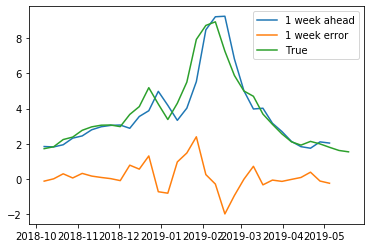

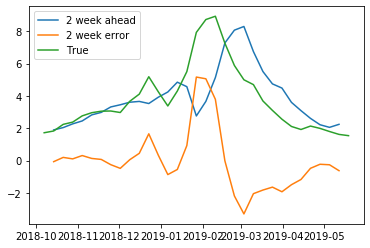

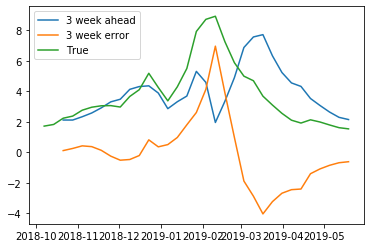

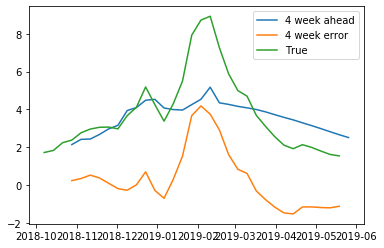

In [36]:
import matplotlib.pyplot as plt
for i in [1,2,3,4]:
    plt.figure(i)
    plt.plot(df_res['{} week ahead'.format(i)], label='{} week ahead'.format(i))
    plt.plot(df_res[targ_dict['target']]-df_res['{} week ahead'.format(i)], label='{} week error'.format(i))
    plt.plot(df_res[targ_dict['target']], label='True')
    plt.legend()
# plt.plot(df_res['2 week ahead'], label='2 week ahead')
# plt.plot(df_res['3 week ahead'], label='3 week ahead')
# plt.plot(df_res['4 week ahead'], label='4 week ahead')

# plt.plot(df_res[targ_dict['target']], label='True')
# plt.legend()
# plt.show()

In [52]:
pwd


'/Users/A.Adiga/work/Forecasting/ARLR_codes/scripts'

In [51]:
(np.array(df_res[targ_dict['target']]-df_res['{} week ahead'.format(i)].dropna())**2/30

SyntaxError: unexpected EOF while parsing (<ipython-input-51-fa5bc4e117cd>, line 1)

In [381]:
for i in [[1,2,3] or [7,8]]:
    print(i)

[1, 2, 3]


In [321]:
pd.merge(df_res, df_m[df_m['DATE']>=(ews][targ_dict['target']])

KeyError: '%UNWEIGHTED ILI'

In [309]:
for ews in epi.Year(2018).iterweeks():
    if ews.week >=40:
        print(ews.startdate())

2018-09-30
2018-10-07
2018-10-14
2018-10-21
2018-10-28
2018-11-04
2018-11-11
2018-11-18
2018-11-25
2018-12-02
2018-12-09
2018-12-16
2018-12-23


In [314]:
all_rgsr

[1,
 2,
 3,
 4,
 52,
 'flu',
 'cough',
 'fever',
 'influenza',
 'cold',
 'temperature_mean',
 'AH_mean',
 'cloud_cover_mean']

In [291]:
df_res[df_res['DATE'] == (ews+i).startdate()][]

,DATE,1 week ahead,2 week ahead,3 week ahead,4 week ahead
3,2018-10-28,NaN,NaN,NaN,NaN


In [191]:
fdf[(fdf['REGION']==region) & (fdf['DATE']>=ews.startdate()) &(fdf['DATE']<=(ews+4).startdate())]

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS,DATE
DATE,,,,,,,,,,,,,,,,
2018-09-30,States,Alabama,2018,40,NaN,1.62738,NaN,NaN,NaN,NaN,NaN,NaN,640.0,82.0,39327.0,2018-09-30
2018-10-07,States,Alabama,2018,41,NaN,1.72381,NaN,NaN,NaN,NaN,NaN,NaN,635.0,82.0,36837.0,2018-10-07
2018-10-14,States,Alabama,2018,42,NaN,1.83318,NaN,NaN,NaN,NaN,NaN,NaN,658.0,82.0,35894.0,2018-10-14
2018-10-21,States,Alabama,2018,43,NaN,2.24187,NaN,NaN,NaN,NaN,NaN,NaN,857.0,83.0,38227.0,2018-10-21
2018-10-28,States,Alabama,2018,44,NaN,2.38157,NaN,NaN,NaN,NaN,NaN,NaN,914.0,84.0,38378.0,2018-10-28


In [209]:
coeffs_f

array([[ 0.        ,  0.93666412,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.18632561,  0.        ,
         0.        ,  0.        ,  0.        , -0.0103118 ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.83541857,  0.        ,  0.        ,
         0.        ,  0.     

In [98]:
[lags_app_f[i] for i in [1,2,3,4,52]]


IndexError: index 4 is out of bounds for axis 0 with size 4

In [ ]:
rgsrs_to_indices(all_exog_rgsr, [1,2,3,4,52], all_exog_rgsr)

In [74]:
lags_app_f[0,:].astype(int)

array([ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 54, 55,  0,  0,  0,  0,  0])

In [210]:
# Granger test to find the realtive importance of different time series

for i in range(0,30):

    

    df_m, targ_dict = ARLR_regressor(fdf, df_wtr, df_ght, region, mask_targ, ews)
    stnry, all_rgsr = stationarity_test(df_m, [1,2,3,4,52], targ_dict, 208)
    df_gr_temp = grangers_test(df_m, [1,2,3,4,52], targ_dict, 208, ews, verbose=False)
    if i ==0:
        df_gr = df_gr_temp
    else:
        df_gr = df_gr.append(df_gr_temp)
df_gr = df_gr.set_index('DATE')

plt.figure(figsize=(15,6))
ax = sns.heatmap(df_gr.astype(float).transpose(), cmap='RdYlGn_r', linewidths=0.5)


NameError: name 'stationarity_test' is not defined

In [32]:
import matplotlib.pyplot as plt

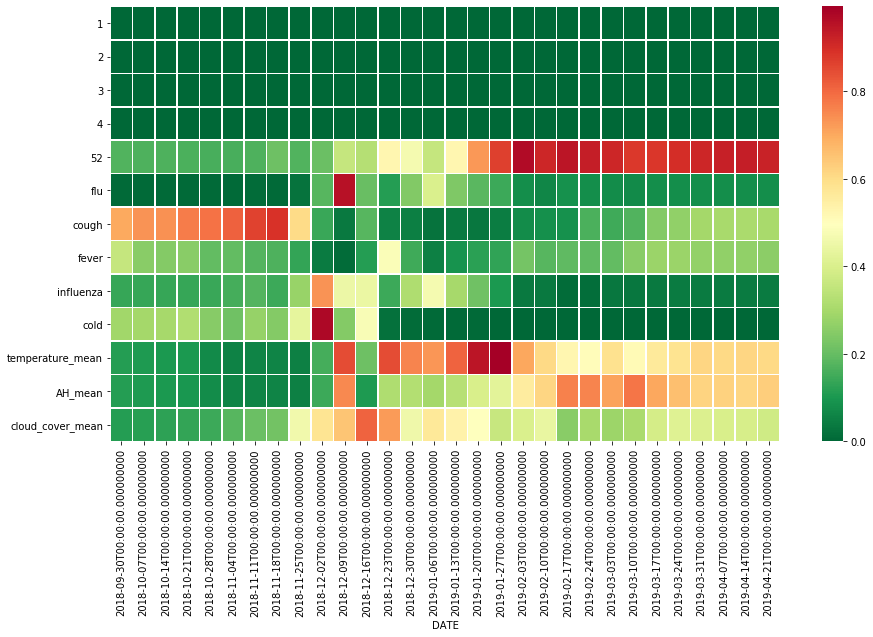

In [35]:
plt.figure(figsize=(15,8))
ax = sns.heatmap(df_gr.astype(float).transpose(), cmap='RdYlGn_r', linewidths=0.5)


In [211]:
def stationarity_test(df_m, lags, targ_dict, win):
    '''df_m: DataFrame that contains data upto forecast date, hence, for "ili" no values are present but it is present for ght and weather, exogenous variables provide a prior to forecast as they contain forecast week information''' 
    all_exog_rgsr = get_exog_reg(targ_dict)
    y = (np.flip(df_m[targ_dict['target']]))
    y_obs = y[1:win+1] # 1 shift as we will have current week data for ght and weather for which we provide forecast
    ind = y_obs.index
    y_obs = np.array(y_obs.values)
    lags_chk = list(np.array(lags).astype(int)) # lags pertaining to AR coeffs
    lags_chk_all = lags_chk+all_exog_rgsr
    all_rgsr = lags_chk+all_exog_rgsr
    lags_app = []
    
    err_old = np.linalg.norm(y_obs)#np.random.randn(win,1))
    tr_tp = np.zeros([win,len(lags_chk_all)])
    
    init_lags_len = len(lags_chk_all)
    
    for k in range(0,init_lags_len):
        err_m = np.zeros([len(lags_chk_all)])
        stnry = np.zeros([len(lags_chk_all)])
        jj = 0
        for i in lags_chk_all:            
            if str(i).isdigit(): # check if it is a lag or exog column
                result = adfuller(y[(i+1):(win+i+1)])
            else:
                exog_reg = df_m[i].values # reads the column name in the dataframe specified by name="i"
                exog_reg = exog_reg[min(lags_chk):(min(lags_chk)+win)] # Most recent date -1 week's data used for exog. variable for training 
                exog_reg = np.flip(exog_reg)
#                 pdb.set_trace()
                result = adfuller(exog_reg[0:win])
        
            stnry[jj] = result[1]
#             pdb.set_trace()
            jj+=1
    return stnry, all_rgsr

In [212]:
df_m, targ_dict = ARLR_regressor(fdf, df_wtr, df_ght, region, mask_targ, ews)
stnry, all_rgsr = stationarity_test(df_m, [1,2,3,4,52], targ_dict, 208)

In [213]:
dict(zip(all_rgsr, stnry))

{1: 0.006571404913929404,
 2: 0.006824664671557762,
 3: 0.006009609215846784,
 4: 0.005853792383048906,
 52: 0.0017095193342235848,
 'flu': nan,
 'cough': nan,
 'fever': nan,
 'influenza': nan,
 'cold': nan,
 'temperature_mean': 2.2488039065666208e-07,
 'AH_mean': 8.072422059227359e-07,
 'cloud_cover_mean': 0.0012354387073720162}

In [216]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=1
test = 'ssr_chi2test'
def grangers_test(df_m, lags, targ_dict, win, ews, test='ssr_chi2test', verbose=False):    
    all_exog_rgsr = get_exog_reg(targ_dict)
    y = (np.flip(df_m[targ_dict['target']]))
    y_obs = y[1:win+1] # 1 shift as we will have current week data for ght and weather for which we provide forecast
    ind = y_obs.index
    y_obs = np.array(y_obs.values)
    lags_chk = list(np.array(lags).astype(int)) # lags pertaining to AR coeffs
    lags_chk_all = lags_chk+all_exog_rgsr
    all_rgsr = lags_chk+all_exog_rgsr
    lags_app = []
    
    err_old = np.linalg.norm(y_obs)#np.random.randn(win,1))
    tr_tp = np.zeros([win,len(lags_chk_all)])
    
    init_lags_len = len(lags_chk_all)
    df = pd.DataFrame(columns=all_rgsr)
    

    for k in range(0,init_lags_len):
        err_m = np.zeros([len(lags_chk_all)])
        stnry = np.zeros([len(lags_chk_all)])
        jj = 0
        for i in lags_chk_all:            
            if str(i).isdigit(): # check if it is a lag or exog column
                test_result = grangercausalitytests(np.array([np.array(y_obs), np.array(y[(i+1):(win+i+1)])]).T, maxlag=maxlag, verbose=False)
                p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
                min_p_value = np.min(p_values)
                df.loc[0, i] = min_p_value
            else:
                exog_reg = df_m[i].values # reads the column name in the dataframe specified by name="i"
                exog_reg = np.flip(exog_reg)
                exog_reg = exog_reg[min(lags_chk):(min(lags_chk)+win)] # Most recent date -1 week's data used for exog. variable for training 
                test_result = grangercausalitytests(np.array([np.array(y_obs), np.array(exog_reg)]).T, maxlag=maxlag, verbose=False)
                p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
                min_p_value = np.min(p_values)
                df.loc[0, i] = min_p_value
        
#             pdb.set_trace()
            jj+=1
    df['DATE'] = pd.to_datetime(ews.startdate())
    return df

df_gr = grangers_test(df_m, [1,2,3,4,52], targ_dict, 208, ews, verbose=False)

In [217]:
df_m, targ_dict = ARLR_regressor(fdf, df_wtr, df_ght, region, mask_targ, ews)
stnry, all_rgsr = stationarity_test(df_m, [1,2,3,4,52], targ_dict, 208)
df_gr = grangers_test(df_m, [1,2,3,4,52], targ_dict, 208, ews, verbose=False)

In [227]:
indices_to_rgsrs(lags_app_f[0,:].astype(int), [1,2,3,4,52], targ_dict)

KeyError: 0

In [102]:
result = adfuller(df_m[targ_dict['ght_target'][1]][-208:])
print(result)

(-3.1512399594796663, 0.02298635034278366, 7, 200, {'1%': -3.463476079125, '5%': -2.876102355, '10%': -2.574532225}, -56.833401324591534)


In [226]:
targ_dict

{'target': '%UNWEIGHTED ILI',
 'ght_target': ['flu', 'cough', 'fever', 'influenza', 'cold'],
 'aw_target': ['temperature_mean', 'AH_mean', 'cloud_cover_mean']}

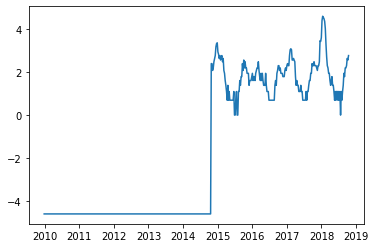

In [84]:
plt.plot(df_m[targ_dict['ght_target'][0]])

In [94]:
ews.startdate()

datetime.date(2018, 10, 7)

In [95]:
y_full = df_m[targ_dict['target']][-208:]


In [ ]:
# %load ARLR.py
'''Contains functions that correspond to the ARLR method'''
from statsmodels.tsa.ar_model import AR
import numpy as np
import statsmodels.api as sm
#import matplotlib.pyplot as plt
import pandas as pd
import pdb, os
from aw_micro import cdc_data
import datetime
# ARLR functions


def ARLR_fct(coeffs,train,lags_app,fct_win, wks):
#     pdb.set_trace()
    lags_app = lags_app[lags_app!=0].astype(int)
    yp_fct = np.zeros([fct_win,1])
    pred_err = np.zeros([fct_win,1])
    y = np.flip(train)
    # test = np.array(test).reshape(fct_win,1)
    pred_win = len(coeffs) # coeffs len
#     y_obs = y[lags_app-1]
    fct_var = y
    fct_var = fct_var[lags_app-1]
    for i in range(0,fct_win):
#         pdb.set_trace()
        yp_fct[i] = np.dot(fct_var,coeffs[lags_app])
        fct_var = np.append(yp_fct[i],fct_var[0:(len(fct_var)-1)])
        #pred_err[i] = test[i]-yp_fct[i]
#         pdb.set_trace()
    #error metrics
#     pdb.set_trace()
    #ind = test[(wks-1):(wks-1+fct_win)].index
    return yp_fct, pred_err



def ARLR_err_met(yp_fct, test):
    fct_win = len(yp_fct)
    e = test[0:fct_win]-(yp_fct)
    RMSE = np.linalg.norm(e)/np.sqrt(fct_win)
    MAE = np.linalg.norm(e,1)/fct_win
    MAPE = np.sum(np.divide(np.abs(e),test))/fct_win
    return RMSE, MAE, MAPE


def create_bootstrap(train, pred_err, coeffs, lags_app, win):
    '''Create bootstrap samples given the prediction error and the AR model'''
#     pdb.set_trace()
    lags_app = lags_app[lags_app!=0].astype(int)
    y = np.flip(train)
    ind = y.index
    err_b = np.random.choice(pred_err,win)
    max_lag = np.max(lags_app).astype('int')    
    yb_temp = np.zeros((win+max_lag))
    yb_temp[win:] = y[win:(win+max_lag)]
    for i in range(win):
        yb_temp[(win-i-1)] = np.dot(yb_temp[win-(i+1)+lags_app]+err_b[i], coeffs[lags_app])
#     pdb.set_trace()
    yb = yb_temp[0:win]
    ind = ind[0:win]
#     yp = yb[-1::-1]
#     ind = ind[-1::-1]
    return yb, ind

# Bootstrapping 
def fct_uncert(train, pred_err,coeffs, lags_app, win, Nb=1000):
    '''Provides Nb forecasts based on the bootstrap samples generated by create_bootstrap fucntion'''
#     pdb.set_trace()
    lags_app = lags_app[lags_app!=0].astype(int)
    yb_mat = np.zeros([Nb,win])
    yb_fct = np.zeros(Nb)
    i=0 # discard outlier sample values
    t_o = 0 # time out variable
    while i < Nb:
#         pdb.set_trace()
        yb_mat[i,:],ind = create_bootstrap(train, pred_err, coeffs, lags_app, win)
#         pdb.set_trace()
        yb_fct[i], pred = ARLR_fct(coeffs,yb_mat[i,:],lags_app,1,1)
        if np.abs(yb_fct[i]) > 100 and t_o<10000:
            t_o+=1
            i+=1
            #pdb.set_trace()
            continue
        else:
            i+=1
#     pdb.set_trace()
    return yb_fct

def uncer_scr(yb_fct, yp_fct, ms_fct, N_b, bin_ed,alp=1e-5):
    '''Puts the bootstrap samples provided by fct_uncert function into bins with bin edges given by bin_ed'''
#     be = np.arange(0,n_bins,.1)
#     be = np.append(be,20)
    bn_mat = np.zeros([len(bin_ed)-1, ms_fct])
    log_scr = 0#np.zeros(ms_fct)
#     pdb.set_trace()
#         plt.subplot(ms_fct,1,i+1)
    bn = np.histogram(np.exp(yb_fct[:]),bins=bin_ed)# plt.plot(y_obs)
    probs = dict(zip(np.round(bn[1],1),bn[0]/N_b))
    #log_scr = np.log(probs[np.floor(np.exp(test)*10)/10.])
    bn_mat = (1-alp)*bn[0]/N_b+alp
    return log_scr, bn_mat

def uncer_Gaussker(yp_fct, ms_fct, pred_err, bin_ed, alp=1e-5):
    '''Puts the bootstrap samples provided by fct_uncert function into bins with bin edges given by bin_ed'''
    std_err = np.std(pred_err)
    bn_mat = np.exp(-((bin_ed[:-1]-np.exp(yp_fct))/(2*3*std_err))**2)
#         plt.subplot(ms_fct,1,i+1)
    #log_scr = np.log(probs[np.floor(np.exp(test)*10)/10.])
    bn_mat = (1-alp)*bn_mat/np.sum(bn_mat)+(alp)
    return bn_mat


def multi_step_fct(data_frame, coeffs, lags_app, train_pred_err, ms_fct, win, Nb, bin_ed, uncer_anl=False):
    '''Using the data_frame, returns 1, 2,... ms_fct-week ahead forecast and also provides the uncertainty in estimation using bootstrap method if uncer_anl=True'''
    yp_fct=np.zeros(ms_fct)
    yb_fct=np.zeros([ms_fct,Nb])
    log_scr = np.zeros(ms_fct)
    bn_mat_bst = np.zeros([len(bin_ed)-1, ms_fct])
    bn_mat_Gaussker = np.zeros([len(bin_ed)-1, ms_fct])
    for wks in range(1,ms_fct+1):
#         pdb.set_trace()
        yp_fct[wks-1],  err = ARLR_fct(coeffs[wks-1,:],data_frame,lags_app[wks-1,:],1, wks)
        #train_pred_err[wks-1,:] = np.roll(train_pred_err[wks-1,:],1)# update error vector for uncertainty analy.
        #train_pred_err[wks-1,0] = data_test[wks-1]-yp_fct[wks-1]
#         pdb.set_trace()
        if uncer_anl:
#             pdb.set_trace()
            yb_fct[wks-1,:] = fct_uncert(data_frame, train_pred_err[wks-1,:],coeffs[wks-1,:],lags_app[wks-1,:], win, Nb)
            log_scr[wks-1], bn_mat_bst[:, wks-1] = uncer_scr(yb_fct[wks-1,:], yp_fct[wks-1], ms_fct, Nb, bin_ed,1e-5)
            bn_mat_Gaussker[:, wks-1] = uncer_Gaussker(yp_fct[wks-1], ms_fct,train_pred_err[wks-1,:], bin_ed, 1e-5)
        print('Week: {}, Fct: {}, Bs: {}, log_scr: {}'.format(wks, np.exp(yp_fct[wks-1]), np.mean(np.exp(yb_fct[wks-1,:])), log_scr[wks-1]))
    return yp_fct, yb_fct, log_scr, bn_mat_bst.reshape([131,4]), bn_mat_Gaussker.reshape([131,4]), train_pred_err

def outputdistribution_bst(predictions,bn_mat, bins, region, target, directory, epi_wk):
    output = pd.DataFrame(columns=['Location', 'Target', 'Type', 'Unit', 'Bin_start_incl', 'Bin_end_notincl', 'Value'])
    df2 = pd.DataFrame(columns=['Location', 'Target', 'Type', 'Unit', 'Bin_start_incl', 'Bin_end_notincl', 'Value'])
    df3 = pd.DataFrame(columns=['Location', 'Target', 'Type', 'Unit', 'Bin_start_incl', 'Bin_end_notincl', 'Value'])
    df4 = pd.DataFrame(columns=['Location', 'Target', 'Type', 'Unit', 'Bin_start_incl', 'Bin_end_notincl', 'Value'])
    
    if region.isdigit():
        df2.loc[0] = ["HHS Region " + region, "Season onset", "Bin", "week", "none", "none", 0.029411765]
    else:
        df2.loc[0] = [region,"Season onset", "Bin", "week", "none", "none", 0.029411765]

    for i in range(40,53):
        if region.isdigit():
            df2.loc[i-39] = ["HHS Region " + region, "Season onset", "Bin", "week", i, i+1, 0.029411765]
        else:
            df2.loc[i-39] = [region, "Season onset", "Bin", "week", i, i+1, 0.029411765]
    for i in range(1, 21):
        if region.isdigit():
            df2.loc[i+14] = ["HHS Region " + region, "Season onset", "Bin", "week", i, i+1, 0.029411765]
        else:
            df2.loc[i+14] = [region, "Season onset", "Bin", "week", i, i+1, .0765]

    for i in range(40, 53):
        if region.isdigit():
            df3.loc[i-40] = ["HHS Region " + region, "Season peak week", "Bin", "week", i, i+1, 0.03030303]
        else:
            df3.loc[i-40] = [region, "Season peak week", "Bin", "week", i, i+1, 0.03030303]
    for i in range(1, 21):
        if region.isdigit():
            df3.loc[i+13] = ["HHS Region " + region, "Season peak week", "Bin", "week", i, i+1, 0.03030303]
        else:
            df3.loc[i+13] = [region, "Season peak week", "Bin", "week", i, i+1, 0.03030303]
    for i in range(bn_mat.shape[0]):
        if region.isdigit():
            df4.loc[i+1] = ["HHS Region " + region, "Season peak percentage", "Bin", "percent", bins[i], bins[i+1], 0.007633588]
        else:
            df4.loc[i+1] = [region, "Season peak percentage", "Bin", "percent", bins[i], bins[i+1], 0.007633588]

    output = output.append(df2)
    output = output.append(df3)
    output = output.append(df4)

    for i in range(predictions.shape[0]):
            df = pd.DataFrame(columns=['Location', 'Target', 'Type', 'Unit', 'Bin_start_incl', 'Bin_end_notincl', 'Value'])
            hist = bn_mat[:,i]
            if region.isdigit():
                df.loc[0] = ["HHS Region " + region, str(i+1) + " wk ahead", "Point", "percent","","", predictions[i]]
            else:
                df.loc[0] = [region, str(i+1) + " wk ahead", "Point", "percent","","", predictions[i]]
    
            
            for j in range(hist.shape[0]):
                if region.isdigit():
                    df.loc[j+1] = ["HHS Region " + region, str(i+1) + " wk ahead", "Bin", "percent", bins[j], bins[j+1], hist[j]]
                else:
                    df.loc[j+1] = [region, str(i+1) + " wk ahead", "Bin", "percent", bins[j], bins[j+1], hist[j]/10]
            
            
            output = output.append(df)
        #pdb.set_trace()
    #Location Target Type Unit Bin_start_incl Bin_end_notincl Value
    filename = 'EW' +'{:02}'.format(epi_wk.week) + '-' + str(epi_wk.year)+ '-FluX_ARLR' +'.csv'
    filepath = os.path.join(directory,filename)
    if not os.path.isfile(filepath):
        output.to_csv(filepath, index=False) 
    else:
        output.to_csv(filepath, mode='a', index=False, header=False)  
    return

def outputdistribution_Gaussker(predictions,bn_mat, bins, region, target, directory, epi_wk):
    if region=='National':
        region = 'US National'
    if (region[len(region)-1]).isdigit():
        region = 'HHS Region ' + region[len(region)-1]
    output = pd.DataFrame(columns=['Location', 'Target', 'Type', 'Unit', 'Bin_start_incl', 'Bin_end_notincl', 'Value'])
    df2 = pd.DataFrame(columns=['Location', 'Target', 'Type', 'Unit', 'Bin_start_incl', 'Bin_end_notincl', 'Value'])
    df3 = pd.DataFrame(columns=['Location', 'Target', 'Type', 'Unit', 'Bin_start_incl', 'Bin_end_notincl', 'Value'])
    df4 = pd.DataFrame(columns=['Location', 'Target', 'Type', 'Unit', 'Bin_start_incl', 'Bin_end_notincl', 'Value'])
    
    df2.loc[0] = [region,"Season onset", "Bin", "week", "none", "none", 0.029411765]

    for i in range(40,53):
        df2.loc[i-39] = [region, "Season onset", "Bin", "week", i, i+1, 0.029411765]
    
    for i in range(1, 21):
        df2.loc[i+14] = [region, "Season onset", "Bin", "week", i, i+1, 0.029411765]

    for i in range(40, 53):
        df3.loc[i-40] = [region, "Season peak week", "Bin", "week", i, i+1, 0.03030303]
    for i in range(1, 21):
        df3.loc[i+13] = [region, "Season peak week", "Bin", "week", i, i+1, 0.03030303]

    for i in range(bn_mat.shape[0]):
        df4.loc[i+1] = [region, "Season peak percentage", "Bin", "percent", bins[i], bins[i+1], 0.007633588]

    output = output.append(df2)
    output = output.append(df3)
    output = output.append(df4)

    for i in range(predictions.shape[0]):
            df = pd.DataFrame(columns=['Location', 'Target', 'Type', 'Unit', 'Bin_start_incl', 'Bin_end_notincl', 'Value'])
            hist = bn_mat[:,i]
            df.loc[0] = [region, str(i+1) + " wk ahead", "Point", "percent","","", predictions[i]]
    
            
            for j in range(hist.shape[0]):
                df.loc[j+1] = [region, str(i+1) + " wk ahead", "Bin", "percent", bins[j], bins[j+1], hist[j]]
            
            
            output = output.append(df)
    #Location Target Type Unit Bin_start_incl Bin_end_notincl Value
    filename = 'EW' +'{:02}'.format(epi_wk.week) + '-' + str(epi_wk.year)+ '-FluX_ARLR'+ '.csv'

    filepath = os.path.join(directory,filename)
    if not os.path.isfile(filepath):
        output.to_csv(filepath, index=False) 
    else:
        output.to_csv(filepath, mode='a', index=False, header=False)  
    return
    
def accu_output(predictions, region, accu_file, ews, st_fips_path):
    df_s = pd.read_csv(st_fips_path)
    st_fips_val = df_s[df_s['state_name']==region]['state']
    pred_state = []
    output = pd.DataFrame(columns=['date', 'area_id', 'ili'])
    for i in range(predictions.shape[0]):
        prediction_date = cdc_data.ew2date(ews.year,ews.week+i)
        pred_state.append({'date':prediction_date.isoformat(),'area_id':'{:02}'.format(st_fips_val.values[0]),'ili':predictions[i]})
        df_state = pd.DataFrame(pred_state)
    output=output.append(df_state)
    if not os.path.isfile(accu_file):
        output.to_csv(accu_file, index=False) 
    else:
        output.to_csv(accu_file, mode='a', index=False, header=False)  
    return

def outputdistribution_fromtemplate(predictions,bn_mat, bins, region, target, directory, epi_wk):
    if region=='National':
        region = 'US National'
    if (region[len(region)-1]).isdigit():
        region = 'HHS ' + region

    filename = 'EW' +'{:02}'.format(epi_wk.week) + '-' + str(epi_wk.year)+ '-FluX_ARLR'+ '.csv'

    filepath = os.path.join(directory,filename)
    if not os.path.isfile(filepath):
        tpl_path = '/project/biocomplexity/aniadiga/Forecasting/cdc-flusight-ensemble/model-forecasts/component-models/Delphi_Uniform'
        if str(epi_wk.year) == '2014':
            tpl_file = 'EW01-2014-Delphi_Uniform.csv'#'EW' +'{:02}'.format(epi_wk.week) + '-' + str(epi_wk.year)+ '-Delphi_Uniform'+ '.csv'
        else:
            tpl_file = 'EW01-2011-Delphi_Uniform.csv'
    
        tpl_df = pd.read_csv(os.path.join(tpl_path,tpl_file))
        tpl_df.to_csv(filepath, index=False)
        df = pd.read_csv(filepath)
    else:
        df = pd.read_csv(filepath)
    
    for i in range(predictions.shape[0]):
        targ_week = '{} wk ahead'.format(i+1)
        mask1 = (df.Location==region)&(df.Target==targ_week)&(df.Type=='Point')
        mask2 = (df.Location==region)&(df.Target==targ_week)&(df.Type=='Bin')
        df.loc[mask1,'Value'] = predictions[i]
        df.loc[mask2,'Value'] = bn_mat[:,i]
    
    df.to_csv(filepath, mode='w', index=False)
    return



In [ ]:
plt.plot(df_test[target].values)
plt.plot(np.exp(seas))

In [ ]:
st_df=pd.read_csv('../data/state_fips.csv')
st_df[st_df['state']==2]['state_name'].values[0]

In [58]:
ews

Week(2018, 50, CDC)

In [ ]:
import matplotlib.pyplot as plt

In [60]:
df_m

NameError: name 'df_m' is not defined

In [ ]:
df[(df['WEEK']==40)&(df['YEAR']==2018)]

In [ ]:
def ARLR_with_exog_aug_phase(train,exog,lags,win,llr_tol=1e-2):
    y = np.flip(train)
    y_obs = y[0:win]
    ind = y_obs.index
    y_obs = np.array(y_obs.values)
    
    x_exog = np.flip(exog,axis=0)
    x_exog = x_exog[0:win,:]
    
    lags = list(lags)
    lags_chk = np.array(lags).astype(int)
    lags_app = np.array([]).astype(int)
    
    init_lags_len = len(lags)+x_exog.shape[1]
    
    err_old = np.linalg.norm(y_obs)#np.random.randn(win,1))
    tr_tp = np.zeros([win,len(lags)])
    
    
    
    
    for k in range(0,init_lags_len):
        err_m = np.zeros([len(lags_chk)])
        llr = np.zeros([len(lags_chk)])
        jj = 0
        
        for i in lags_chk:
#             pdb.set_trace()
            tr_tp[:,k] = y[i:(win+i)]
            tr_tp_mul = np.matmul(tr_tp[:,0:(k+1)].T, tr_tp[:,0:(k+1)])
            res = sm.OLS(y_obs,tr_tp[:,0:(k+1)]).fit()
            yp = res.predict()
            err_m[jj] = np.linalg.norm(y_obs-yp)
            llr[jj] = 2*np.log(err_old/err_m[jj])
#             pdb.set_trace()
            jj+=1            
        imax = np.argmax(llr)
    #     p_val = chi2.sf(llr[imax],1)
    #     print(p_val)
        if llr[imax] >= llr_tol:
#             pdb.set_trace()
            tr_tp[:,k] =y[lags_chk[imax]:(win+lags_chk[imax])]
            lags_app = np.append(lags_app, lags_chk[imax])
            lags_chk = np.delete(lags_chk, imax)
            err_old = err_m[imax]
#             pdb.set_trace()
        else:
#             pdb.set_trace()
            break
    res = sm.OLS(y_obs,tr_tp[:,0:(k)]).fit()
    yp = res.predict()
    return res, yp, y_obs, tr_tp, llr, err_old, lags_app, ind

def ARLR_red_phase(y,tr_tp,err_old, lags, res1, lags_app,ind, llr_tol=1e-2):
    tot_col = len(lags_app)
    temp_tr_tp = tr_tp[:,0:tot_col]
    for i in range(0,tot_col+1):
        init_lag_len_new = temp_tr_tp.shape[1]
        jj = 0 
        err_m = np.zeros([len(lags)])
        llr = np.zeros([len(lags)])
        for k in range(0,init_lag_len_new):
#             pdb.set_trace()
            res = sm.OLS(y,np.delete(temp_tr_tp,k,1)).fit()
            yp = res.predict()
            err_m[jj] = np.linalg.norm(y-yp)
            llr[jj] = 2*np.log(err_old/err_m[jj])
            jj+=1
        imin = np.argmin(llr)
        if (llr[imin]>llr_tol):
            temp_tr_tp = np.delete(temp_tr_tp,imin,1)     
            err_old = err_m[imin]
#             pdb.set_trace()
        else:
#             pdb.set_trace()
            break
    res = sm.OLS(y,temp_tr_tp).fit()
    yp = res.predict()
    pred_err = y-yp
    return res, yp, tr_tp, llr, pred_err, res1, lags_app, ind

In [ ]:
df_ex = prep_aw_data(aw_csv_path, mask_wtr)
df_ex.columns

In [ ]:
col_mask = ['temperature_mean','AH_mean','wind_speed_mean','cloud_cover_mean','ep_st_date','date']
df_ex_2 = df_ex[col_mask]


In [ ]:
len(wtr.columns)


In [ ]:
pred_date = cdc_data.ew2date(2019,41)
pred_date

In [ ]:
cdc_data.date2ew(2019)

In [ ]:
import dateutil

In [ ]:
pp = pd.to_datetime([epi.Week(int(cdc_data.date2ew(d.date())[0]),int(cdc_data.date2ew(d.date())[1])).startdate() for d in pd.to_datetime(df_ex.date)])

In [ ]:
df_ex['ep_st_date'] = pp

In [ ]:
df_ex

In [ ]:
df_ght = pd.read_csv('../data/dataverse_files/google_trends.csv')

In [ ]:
ls ../data/dataverse_files/

In [ ]:
df_srs = df_ght.columns.values
df_srs

In [ ]:
with open('ght_list.txt', 'w') as filehandle:
    for listitem in df_ght.columns:
        filehandle.write('%s\n' % listitem)

In [ ]:
pwd

In [ ]:
(epi.Week(2019,42).enddate()+timedelta(days=9)).isoformat()

In [ ]:
ews+1